
# Semi-Supervised ML
In the semi-supervised setting, a large unlabeled dataset and a small labeled dataset are given. The goal is to train a classifier on the entire dataset that would predict the labels of the unlabeled data points in the training set. This is called transductive semi-supervised learning. In the present problem, we have created a semi-supervised learning dataset consisting of $92\%$  unlabeled data points and $8\%$ labeled data points.

Using self-training semi-supervised learning method, we've trained the following three base classifiers:

- Logistic Regression 

- Random Forest 

- XGBoost 

We use the ground truth (true lables) of the unlabeled dataset to validate the performance of the self-training semi-supervised learning models, but in reality the ground truth of the unlabeled data points will not be provided.

In [1]:
%matplotlib inline

# Ignore deprecated warning
import warnings

warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split

plt.rcParams.update({'font.size': 15})

In [2]:
# Import custom class
%run -i '../src/ss_transfxns.py'
%run -i '../src/ss_ml.py'
%run -i '../src/sup_ml.py'

In [3]:
# Instantiate the class
transfxn = TransformationPipeline()
model = SemiSupervised()

# Load data

In [4]:
df = pd.read_csv('../data/kdd99-unsupervised-ad.csv', header=None)
print("Data size:", df.shape) # print data size
df.columns = ['v_{}'.format(i) for i in range(30)] 
# df = (df.sample(frac =1)).reset_index(drop = True) # Shuffle the data
df.head() # display the data

Data size: (620098, 30)


,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,...,v_20,v_21,v_22,v_23,v_24,v_25,v_26,v_27,v_28,v_29
0,0.0,215.0,45076.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,n
1,0.0,162.0,4528.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,n
2,0.0,236.0,1228.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,n
3,0.0,233.0,2032.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,3.0,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,n
4,0.0,239.0,486.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,4.0,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,n


# Categorical variables encoded as integers

In [5]:
# Convert to string
cols = ['v_6', 'v_7', 'v_8', 'v_9']
for i, val in enumerate(cols):
    df[val] = df[val].astype('O')

# Create feature matrix and class label

In [6]:
X, y = df.drop('v_29', axis = 1), df.v_29

# Create unlabeled dataset
In this section, we remove some labels and relabel them as unknown, which is indicated by -1

In [7]:
# Map to binary
y_ = y.map({'n':0, 'o':1})

In [8]:
X_u, X_l, y_u, y_l = train_test_split(X,y_, test_size=0.08, stratify=y_, random_state=42)

In [9]:
unlabeled_set = list(X_u.index) # unlabeled indices
y_train = np.copy(y_) # copy labels
y_train[unlabeled_set] = -1 # set unlabeled dataset to -1
y_true = y_[unlabeled_set] # True labels of the unlabeled dataset

In [10]:
print("Original class distribution")
print('-'*25)
label_pct = y_.map({0:'normal',1: 'attack'}).value_counts()*100/len(y_)
label_ct =  y_.map({0:'normal',1: 'attack'}).value_counts()
pd.DataFrame(
    {
        'labels': label_pct.index, 
        'count': label_ct.values, 
        'percentage': label_pct.values,
    }
)

Original class distribution
-------------------------


,labels,count,percentage
0,normal,619046,99.830349
1,attack,1052,0.169651


In [11]:
print("Class distribution for semi-supervised learning")
print('-'*45)
label_pct = pd.Series(y_train).map({0:'normal',1: 'attack', -1: 'unknown'})\
                .value_counts(normalize=True)*100
label_ct =  pd.Series(y_train).map({0:'normal',1: 'attack', -1: 'unknown'}).value_counts()
pd.DataFrame(
    {
        'labels': label_pct.index, 
        'count': label_ct.values,
        'percentage': label_pct.values,
    }
)

Class distribution for semi-supervised learning
---------------------------------------------


,labels,count,percentage
0,unknown,570490,91.999974
1,normal,49524,7.986480
2,attack,84,0.013546


In [12]:
print(" Class distribution for true labels of the unlabeled dataset")
print('-'*45)
label_pct = y_true.map({0:'normal',1: 'attack'}).value_counts()*100/len(y_true)
label_ct =  y_true.value_counts()
pd.DataFrame(
    {
        'labels': label_pct.index, 
        'count': label_ct.values,
        'percentage': label_pct.values,
    }
)

 Class distribution for true labels of the unlabeled dataset
---------------------------------------------


,labels,count,percentage
0,normal,569522,99.830321
1,attack,968,0.169679


# Transformation pipeline

In [13]:
# Transform and scale data
X_train_scaled, feat_nm = transfxn.preprocessing(X)

In [14]:
print(f'Training set size after pre-processing: {X_train_scaled.shape, y_train.shape}')

Training set size after pre-processing: (620098, 33) (620098,)


#  Self-Training Semi-Supervised Learning

# A-1. Logistic Regression

In [15]:
lr_base_classifier = LogisticRegression(random_state = 42)
lr_y_pred, y_proba = model.self_training_clf(
    lr_base_classifier, X_train_scaled, y_train,
    threshold=0.75, max_iter=None,verbose=True
)

print('-' * 40)
print(f"Predicted labels for {len(y_true)} unlabeled data points:")
pd.Series(lr_y_pred[unlabeled_set]).value_counts()

End of iteration 1, added 570476 new labels.
End of iteration 2, added 9 new labels.
End of iteration 3, added 3 new labels.
----------------------------------------
Predicted labels for 570490 unlabeled data points:


0    569516
1       974
dtype: int64

# A-1-1. Performance metrics

We use the ground truth of the unlabeled dataset to validate the performance of the model, but in reality the ground truth of the unlabeled data points will not be provided

In [16]:
model.eval_metrics(y_true.values, lr_y_pred[unlabeled_set], 
                        model_nm='Logistic Regression')

Test predictions for Logistic Regression
------------------------------------------------------------
Accuracy:  0.999940
AUROC: 0.992751
AUPRC: 0.965325
Predicted classes: [0 1]
Confusion matrix:
 [[569502     20]
 [    14    954]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    569522
           1       0.98      0.99      0.98       968

    accuracy                           1.00    570490
   macro avg       0.99      0.99      0.99    570490
weighted avg       1.00      1.00      1.00    570490

------------------------------------------------------------


# A-1-2. PCA plot

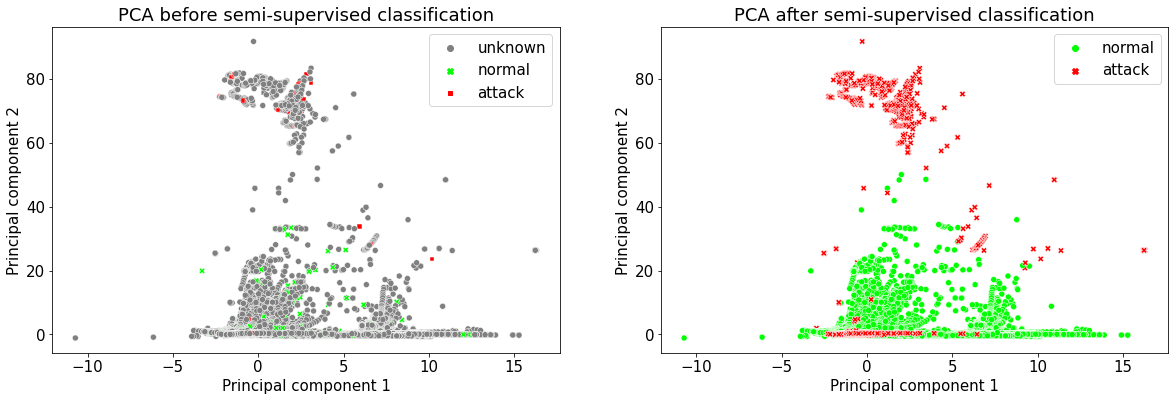

In [17]:
# Re-encode the class variable
y_train_ = pd.Series(y_train).map({0:'normal',1: 'attack', -1: 'unknown'})
lr_y_pred = pd.Series(lr_y_pred).map({0:'normal',1: 'attack'})

transfxn.plot_pca(X_train_scaled, y_train_, lr_y_pred)

# A-2. Random Forest

In [18]:
param_dist = {'n_estimators':100, 'random_state':42}
rf_base_classifier = RandomForestClassifier(**param_dist)
rf_y_pred, y_proba = model.self_training_clf(
    rf_base_classifier, X_train_scaled, y_train,
    threshold=0.75, max_iter=None,verbose=True
)

print('-' * 40)
print(f"Predicted labels for {len(y_true)} unlabeled data points:")
pd.Series(rf_y_pred[unlabeled_set]).value_counts()

End of iteration 1, added 570406 new labels.
End of iteration 2, added 32 new labels.
End of iteration 3, added 4 new labels.
End of iteration 4, added 4 new labels.
End of iteration 5, added 1 new labels.
End of iteration 6, added 3 new labels.
----------------------------------------
Predicted labels for 570490 unlabeled data points:


0    569549
1       941
dtype: int64

# A-2-1. Performance metrics
We use the ground truth of the unlabeled dataset to validate the performance of the model, but in reality the ground truth of the unlabeled data points will not be provided

In [19]:
model.eval_metrics(y_true.values, rf_y_pred[unlabeled_set],
                     model_nm='Random Forest Classifier')

Test predictions for Random Forest Classifier
------------------------------------------------------------
Accuracy:  0.999949
AUROC: 0.985536
AUPRC: 0.970092
Predicted classes: [0 1]
Confusion matrix:
 [[569521      1]
 [    28    940]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    569522
           1       1.00      0.97      0.98       968

    accuracy                           1.00    570490
   macro avg       1.00      0.99      0.99    570490
weighted avg       1.00      1.00      1.00    570490

------------------------------------------------------------


# A-2-2. PCA plot

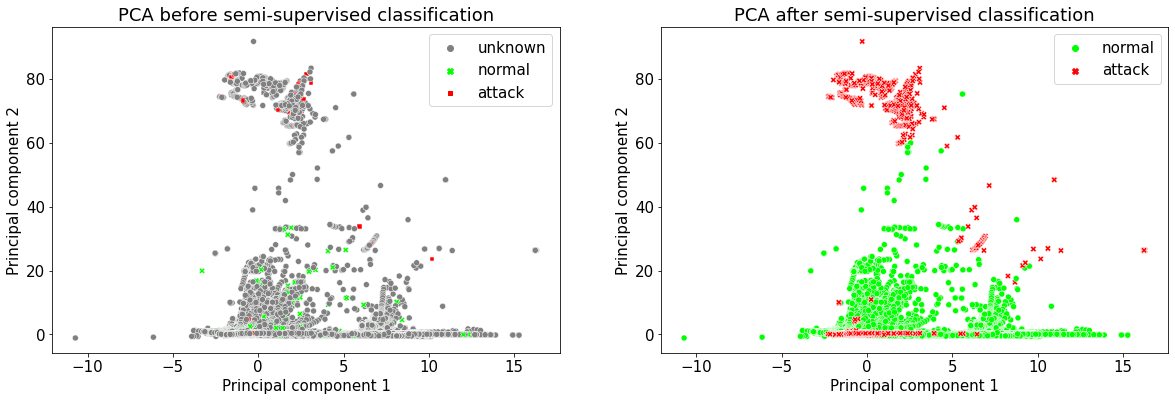

In [20]:
# Re-encode the class variable
y_train_ = pd.Series(y_train).map({0:'normal',1: 'attack', -1: 'unknown'})
rf_y_pred = pd.Series(rf_y_pred).map({0:'normal',1: 'attack'})

transfxn.plot_pca(X_train_scaled, y_train_, rf_y_pred)

# A-3. XGBoost

In [24]:
param_dist = {'objective':'binary:logistic', 'eval_metric':'logloss', 
              'n_estimators':100, 'learning_rate':0.1, 'random_state':42
            }
                
xgb_base_classifier = XGBClassifier(**param_dist)
xgb_y_pred, y_proba = model.self_training_clf(xgb_base_classifier, X_train_scaled, y_train,
                                          threshold= 0.75, max_iter = None,verbose = True)
print('-' * 40)
print(f"Predicted labels for {len(y_true)} unlabeled data points:")
pd.Series(xgb_y_pred[unlabeled_set]).value_counts()

End of iteration 1, added 570473 new labels.
End of iteration 2, added 17 new labels.
----------------------------------------
Predicted labels for 570490 unlabeled data points:


0    569518
1       972
dtype: int64

# A-3-1. Performance metrics
We use the ground truth of the unlabeled dataset to validate the performance of the model, but in reality the ground truth of the unlabeled data points will not be provided

In [25]:
model.eval_metrics(y_true.values, xgb_y_pred[unlabeled_set],
                     model_nm='XGBoost Classifier')

Test predictions for XGBoost Classifier
------------------------------------------------------------
Accuracy:  0.999944
AUROC: 0.992753
AUPRC: 0.967311
Predicted classes: [0 1]
Confusion matrix:
 [[569504     18]
 [    14    954]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    569522
           1       0.98      0.99      0.98       968

    accuracy                           1.00    570490
   macro avg       0.99      0.99      0.99    570490
weighted avg       1.00      1.00      1.00    570490

------------------------------------------------------------


# A-3-2. PCA plot

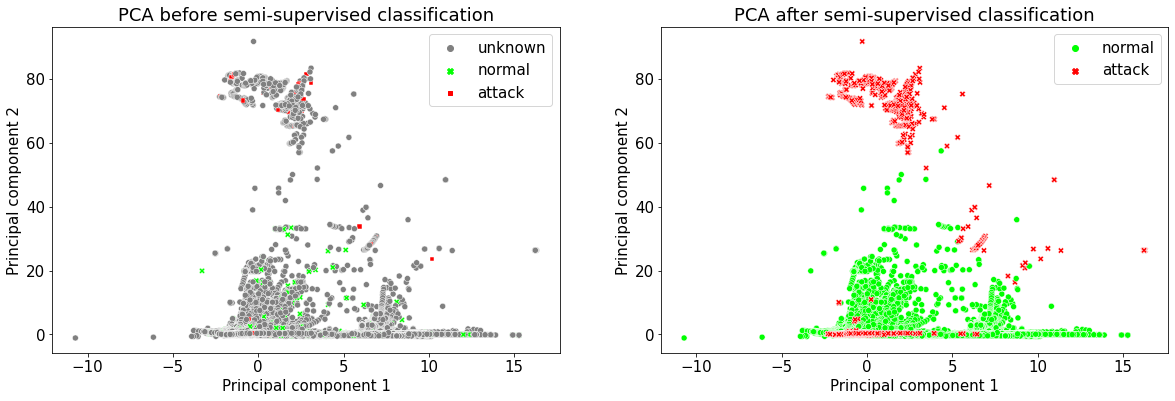

In [26]:
# Re-encode the class variable
y_train_ = pd.Series(y_train).map({0:'normal',1: 'attack', -1: 'unknown'})
xgb_y_pred = pd.Series(xgb_y_pred).map({0:'normal',1: 'attack'})

transfxn.plot_pca(X_train_scaled, y_train_, xgb_y_pred)

# Graph-Based Semi-Supervised Learning

# A-1. Label Spreading

In [ ]:
ls_y_pred, y_proba = model.label_spread(X_train_scaled, y_train, gamma = 20, max_iter = 30)

print('-' * 40)
print(f"Predicted labels for {len(y_true)} unlabeled data points:")
pd.Series(ls_y_pred[unlabeled_set]).value_counts()

# A-1-1. Performance metrics
We use the ground truth of the unlabeled dataset to validate the performance of the model, but in reality the ground truth of the unlabeled data points will not be provided

In [ ]:
model.eval_metrics(y_true.values, ls_y_pred[unlabeled_set], model_nm='Label Spreading')

# A-1-2. PCA plot

In [ ]:
# Re-encode the class variable
y_train_ = pd.Series(y_train).map({0:'normal',1: 'attack', -1: 'unknown'})
xgb_y_pred = pd.Series(ls_y_pred).map({0:'normal',1: 'attack'})

transfxn.plot_pca(X_train_scaled, y_train_, ls_y_pred)